# Stock Price Prediction 

In [1]:
(solving the wrong problem!) MARCOS FETURES

SyntaxError: invalid syntax (<ipython-input-1-9a58aa2f05fd>, line 1)

# I) Description of the problem

### On the problem.

* The problem of stock prediction concerns of being able to forecast a *Weakly Non stationary Time Series* so one can **sell** an active at a higher **Ask Price** that is was it's **Bid price** (buying at a smaller price than it was previously sold).


### On the properties of the data.

* Stocks, ETF's, hedge funds, can be modeled instantaneously as two Weakly Non stationary Time Series, one for *bid* prices and one for *ask* prices. By weakly Non stationary Time Series ($X(t)$), it is meant:

<center>
    First momentum invariance. (Trends in marked do not follow this)
</center>
$$E[X(t)] = E[X(t + \epsilon)]$$ <br/>




<center>
    Second momentum invariance. (Varying volatility of the market do not follow this)
</center>
$$C(X(t)) = C(X(t + \alpha)) = E[(X(t) - E[X(t)])(X(t + \epsilon) - E[X(t + \epsilon)])]$$ <br/>




<center>
    Bounded energy. (The very nature of inflation do not follow this)
</center>
$$E[|X(t)|^2] < \infty $$ <br/>




* So, one should interpret this data as not predictable for longer distances but, among several, one can depicts a few techniques to be able to predict those series. Namely:

    - Short term predictions: It transforms a non-stationary series in a locally stationary series. Thus, predictable.
    - Using the first order derivative ($r(t) = (x(t) - x(t - 1))$): It erases the 'memory' of a non-stationary series. This is also called **RETURNS** of a financial time series.


### On the financial data.

* **Bid's** and **Ask's** are updated at every new *order* in the *order book*, this is called *tick*. For visual chartists, analyzing this *tick* data is too cumbersome, so one of **many** ways of visualizing it, is in the form of **Open, Close, High, Low**, henceforth, nicknamed after *OCHL*. Those are defined as:

![title](assets/ochl.png)


* Among those who do trade stocks, we can find the ones so called *Scalpers* and the *Swing traders*, where, respectively, one places its buy/sell orders in the same day whereas the other waits for several days. We will be dealing with the former.

# II) Loading data

In [94]:
import requests
import quandl
import os

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import *
from tqdm import tqdm_notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
api_key = os.environ['QUANDL_API_KEY']
metadata_filename = 'WIKI_metadata.csv'
dataset_filename = 'WIKI_dataset.csv'
dates_range = ['2000-12-31', '2018-12-31']

## Downloading and extracting the dataset

In [4]:
import zipfile
def get_data(url, filename, extract=True):
    r = requests.get(url, allow_redirects=True)
    filename = filename + '.zip' if extract else filename
    open(filename, 'wb').write(r.content)
    if not extract: return
    zipfile.ZipFile(filename, 'r').extractall('./')

In [5]:
get_data('https://www.quandl.com/api/v3/databases/WIKI/metadata?api_key=%s' % api_key, 
         metadata_filename)

get_data('https://www.quandl.com/api/v3/datatables/WIKI/PRICES/delta.json?api_key=%s' % api_key, 
         dataset_filename, extract=False)

In [6]:
metadata_df = pd.read_csv(metadata_filename)
dataset_df = pd.read_csv(dataset_filename)

In [7]:
metadata_df.sample(10)

,code,name,description,refreshed_at,from_date,to_date
1039,FBHS,Fortune Brands Home & Security Inc. (FBHS) Pri...,"<p>End of day open, high, low, close and volum...",2018-03-27 21:45:58,2011-09-16,2018-03-27
2152,PATK,"Patrick Industries Inc. (PATK) Prices, Dividen...","<p>End of day open, high, low, close and volum...",2018-03-27 21:46:02,1990-03-27,2018-03-27
3156,XOM,"Exxon Mobil Corp. (XOM) Prices, Dividends, Spl...","End of day open, high, low, close and volume, ...",2018-03-27 21:46:12,1970-01-02,2018-03-27
677,CPT,"Camden Property Trust (CPT) Prices, Dividends,...","<p>End of day open, high, low, close and volum...",2018-03-27 21:46:07,1993-07-22,2018-03-27
201,APOL,"Apollo Group Inc. (APOL) Prices, Dividends, Sp...","<p>End of day open, high, low, close and volum...",2017-04-26 13:41:20,1995-01-04,2017-02-01
2102,OME,"Omega Protein Corp. (OME) Prices, Dividends, S...","<p>End of day open, high, low, close and volum...",2017-12-19 22:47:09,1998-04-03,2017-12-19
448,BWLD,"Buffalo Wild Wings Inc. (BWLD) Prices, Dividen...","<p>End of day open, high, low, close and volum...",2018-02-05 22:47:35,2003-11-24,2018-02-05
891,DXYN,"Dixie Group Inc. (DXYN) Prices, Dividends, Spl...","<p>End of day open, high, low, close and volum...",2018-03-27 21:46:08,1990-03-26,2018-03-27
1627,KRG,"Kite Realty Group Trust (KRG) Prices, Dividend...","<p>End of day open, high, low, close and volum...",2018-03-27 21:46:08,2004-08-12,2018-03-27
1702,LNKD,"LinkedIn (LNKD) Prices, Dividends, Splits and ...","<p>End of day open, high, low, close and volum...",2017-04-26 13:34:27,2011-05-19,2016-12-07


In [8]:
dataset_df

,"{""data"":{""files"":[]",latest_full_data:null}}


* Since the api for `get`'ing seems to be not working, we can use the **quandl** module to download the dataset.



* The WIKI dataset has a huge variety of stocks and assets, so, we'll be dealing with either **one** for regression or **four**  when building a portfolio.


In [9]:
quandl.ApiConfig.api_key = api_key

dataset_df = quandl.get_table('WIKI/PRICES', ticker = ['CENX', 'QCOM', 'YHOO', 'MCD'], 
                        date = {'gte': dates_range[0], 'lte': dates_range[1]},
                        paginate=True).reset_index(drop=True)

dataset_df.head()

,ticker,date,open,high,low,close,volume,ex-dividend,split_ratio,adj_open,adj_high,adj_low,adj_close,adj_volume
0,YHOO,2017-06-16,52.79,53.30,51.900,52.5892,251032146.0,0.0,1.0,52.79,53.30,51.900,52.5892,251032146.0
1,YHOO,2017-06-15,52.17,52.76,51.645,52.5800,65808136.0,0.0,1.0,52.17,52.76,51.645,52.5800,65808136.0
2,YHOO,2017-06-14,52.42,54.26,52.160,52.6300,65466397.0,0.0,1.0,52.42,54.26,52.160,52.6300,65466397.0
3,YHOO,2017-06-13,53.65,54.08,52.000,52.0050,152590970.0,0.0,1.0,53.65,54.08,52.000,52.0050,152590970.0
4,YHOO,2017-06-12,53.79,54.55,52.600,53.1200,57480339.0,0.0,1.0,53.79,54.55,52.600,53.1200,57480339.0


## Peaking on the data

In [10]:
from pandas.plotting import register_matplotlib_converters
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates

data_to_plot = dataset_df[dataset_df.ticker == 'MCD'][['open', 'high', 'low', 'close', 'date']].copy()
data_to_plot['date'] = data_to_plot.date.map(mdates.date2num).copy()

In [11]:
%matplotlib inline

c:\python36\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


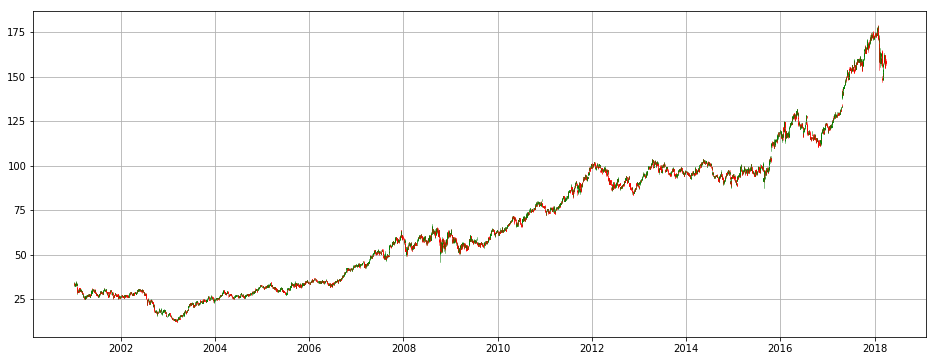

In [12]:
plt.figure(figsize=(16, 6))
ax = plt.subplot()
candlestick_ohlc(ax, data_to_plot[['date', 'open', 'high', 'low', 'close']].values, width=.5, colorup='g', colordown='r')
ax.xaxis_date()
ax.grid()
plt.show()

del data_to_plot

## Train, Validation and test split

* A **true** train/val/test split is one with no **leakage** to/from train/validation/test. 


* So ideally, the test should be another symbol (*e.g.*: train with **Tesla**, validate in another period of time using another asset). 


* But this would only prove the robustness and generalization of our model, while possibly, not maximizing profits in a single asset. Besides, multiple asset analysis is better done using a **Modern Portfolio Theory** (MPT, as proposed by *Markowitz*). 


* Thus, the split will be done in order to only avoid **lookahead bias** (train with day 1 and day 3, and test with day 2).


* Blocked Time Series Splits scheme of cross validation and training of our model will be used. We will also use a training in the whole data giving equal importance to all the data.


![title](assets/cross_validation2.png)


* For testing the data as soon as a architecture or algorithm is defined, we can use the Time Series Splits.:
![title](assets/cross_validation1.png)

In [13]:
TRAIN_VAL_PERCENTAGE = 0.90
TEST_PERCENTAGE = 1 - TRAIN_VAL_PERCENTAGE

full_dates_range = pd.date_range(start=dates_range[0], end=dates_range[1]).sort_values()

train_val_date_range = full_dates_range[:int(len(full_dates_range) * TRAIN_VAL_PERCENTAGE)].sort_values()
test_date_range = pd.DatetimeIndex(set(full_dates_range) - set(train_val_date_range)).sort_values()

In [14]:
dataset_df.loc[dataset_df.date.isin(train_val_date_range), 'set'] = 'TRAIN_VAL'
dataset_df.loc[dataset_df.date.isin(test_date_range), 'set'] = 'TEST'

In [15]:
class BlockingTimeSeriesSplit:
    def __init__(self, n_splits, train_val_percentage=0.8):
        self._train_val_percentage = train_val_percentage
        self._n_splits = n_splits
    
    @property
    def n_splits(self):
        return self._n_splits
    
    def split(self, X):
        n_samples = len(X)
        k_fold_size = n_samples // self._n_splits
        indices = np.arange(n_samples)

        for i in range(self._n_splits):
            begin = i * k_fold_size
            end = begin + k_fold_size
            mid = int(self._train_val_percentage * (end - begin)) + begin
            yield indices[begin:mid], indices[mid:end]

In [16]:
from sklearn.model_selection import TimeSeriesSplit

train_splits = BlockingTimeSeriesSplit(n_splits=6, train_val_percentage=TRAIN_VAL_PERCENTAGE)
testing_splits = TimeSeriesSplit(n_splits=4)

# III) Feature engineering

* As discussed in the first section, it is useful to transform the OCHL features to something manageable mathematically, such as, a (locally) stationary time series.


In [17]:
primary_features_columns = ['open', 'high', 'low', 'close', 'volume']

In [18]:
features_df = dataset_df[primary_features_columns + ['ticker', 'set', 'date']].copy()

## Analytical features

### Daily returns.

* One can use the relative returns of one single day as feature, since it is a first order derivative, thus, conveying stationarity to out time series.

$$\frac{X(t_{close})}{X(t_{open})} - 1$$

In [19]:
features_df['daily_returns'] = (features_df.close / features_df.open) - 1

### Log returns.

* Among the advantages explored in the **section I)** of using returns instead of the raw data, we can further improve the feature of time series so it displays desirable statistical properties. One usual transform is known as **Log-returns**, defined as follows:


$$log(\frac{X(t)}{X(t-1)})$$


* The desirable properties of using log-returns can be summed in as being prone to follow a normal distribution and being able to "accumulate" returns over time with simple additions instead of multiplications)

In [20]:
def log_returns(dataframe):
    sorted_dataframe = dataframe.sort_values(by='date')
    sorted_dataframe['log_returns'] = np.log(sorted_dataframe.close / sorted_dataframe.close.shift(1))
    return sorted_dataframe
    
features_df = features_df.groupby('ticker')\
    .apply(log_returns).droplevel(0)

## Market Features (Techinical indicators)

* For traders who are used to manually trade, It's often used a common analysis called **Technical Analysis**, in which allegedly, it is possible to infer market movements such as *momentum*, *overbought*, *oversold*, *breakout break* and *support breakout* through **technical indicators** such as (*e.g.* MACD, RSI, EMA, Bollinger Bands, Stochastic oscillators).



* There are **no**$^{I}$  proves so far that technical indicators have any real predictive power over the market besides the mere fact that human traders, hedge funds and firms tend to use them, so, by the efficient market hypothesis, the market will react in accordance with those buyers and sellers.


* Thus, we are going to use one of those indicators because it can at least predict if traders are using it too much or otherwise.




<sup>$^{I}$: *Burton G. Malkiel*, A randon walk down wall street.<sup>

### Price-Volume Trend

* Sharp changes in the price that follows a sharp change in volume usually represents a **resistance** or **support**, meaning that traders will consider the market overbought (or oversold) and start to sell (or buy).


* On Balance Volume (OBV) Is an indicator that simply adds or subtracts the volume from a accumulator depending on the return of the current day.

In [21]:
def on_balance_volume(dataframe):
    sorted_dataframe = dataframe.sort_values(by='date')
    previous_row = None
    def _compute_obv_for_row(row):
        nonlocal previous_row
        if previous_row is not None:
            row['obv'] = previous_row['obv'] + row['volume'] if row['close'] > previous_row['close'] else\
                         previous_row['obv'] - row['volume'] if row['close'] < previous_row['close'] else\
                         previous_row['obv']
        else:
            row['obv'] = np.nan
            previous_row = row.copy()
            previous_row['obv'] = .0
        return row

    return sorted_dataframe.apply(_compute_obv_for_row, axis=1)

features_df = features_df.groupby('ticker')\
    .apply(on_balance_volume).reset_index(drop=True)

### Normalization

* In order give no priors to our models, the available features will be normalized by their respective standard deviation in the train so they have the same *a-priori* importance, since their power will always be 1.

In [22]:
# Save standard deviations for reconstructing the data later.
standard_deviation = {}

def normalize(dataframe):
    global standard_deviation
    asset = dataframe.ticker.iloc[0]
    
    feature_columns = primary_features_columns + ['daily_returns', 'log_returns', 'obv']
    _features_df = dataframe[feature_columns]
    
    standard_deviation[asset] = _features_df[dataframe.set == 'TRAIN_VAL'].std()
    _features_df = _features_df.div(standard_deviation[asset])
    
    dataframe[feature_columns] = _features_df
    return dataframe
    
features_df = features_df.groupby('ticker')\
    .apply(normalize).reset_index(drop=True)

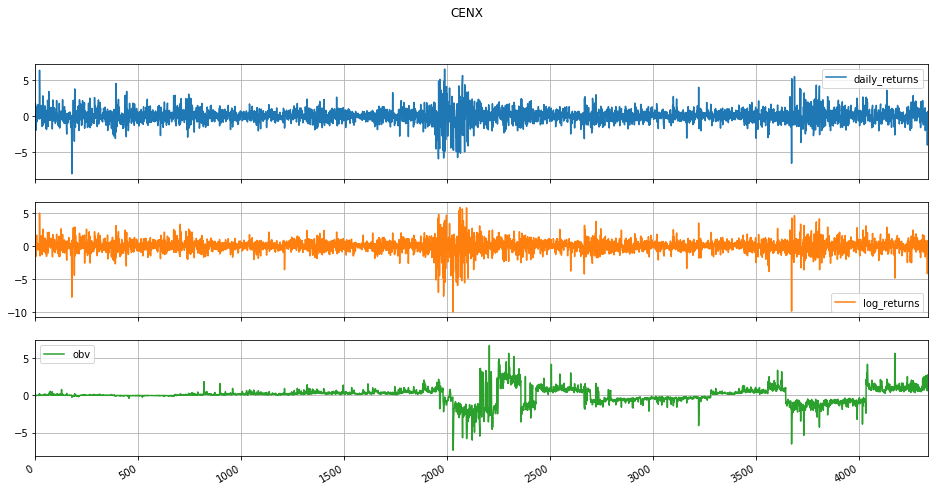

In [23]:
features_df[features_df.ticker == 'CENX'][['daily_returns', 'log_returns', 'obv']]\
    .plot(subplots=True, figsize=(16, 8), grid=True, title='CENX')
plt.show()

$$\frac{log(\frac{X(t)}{X(t-1)})}{std}$$

# IV) Training


## Regression task

* Windows of five days of features with 3 days of overlap will be used for the regression task.

In [24]:
from collections import namedtuple

In [25]:
ASSET_FOR_REGRESSION = 'MCD'

In [26]:
Sample = namedtuple('Sample', ['windowed_features', 'scalar_features', 'target'])

In [27]:
def get_samples_and_targets(
        dataframe, *, 
        target_column, windowed_features_columns=[], 
        scalar_features_columns=[], window_size=5, overlap=3
):
    return [
        Sample(
            windowed_features=dataframe.iloc[idx - window_size:idx][windowed_features_columns].values.copy(),
            scalar_features=dataframe.iloc[idx - 1][scalar_features_columns].values.copy(),
            target=dataframe.iloc[idx][target_column].copy(),
        )
        for idx in range(window_size, len(dataframe), window_size - overlap)
    ]


## Separate the test samples

In [28]:
test_set = features_df[(features_df.ticker == ASSET_FOR_REGRESSION) &\
                       (features_df.set == 'TEST')]

test_set = test_set[primary_features_columns + ['daily_returns', 'log_returns', 'obv', 'date']]\
                .sort_values('date')\
                .reset_index(drop=True)

In [29]:
test_samples = get_samples_and_targets(
    test_set, 
    target_column='log_returns',
    windowed_features_columns=['open', 'high', 'low', 'close'], 
    scalar_features_columns=['daily_returns', 'log_returns', 'obv'],
    window_size=5, overlap=4)

## Create samples for train

In [30]:
train_val_set = features_df[(features_df.ticker == ASSET_FOR_REGRESSION) &\
                            (features_df.set == 'TRAIN_VAL')]

train_val_set = train_val_set[primary_features_columns + ['daily_returns', 'log_returns', 'obv', 'date']]\
                .sort_values('date')\
                .reset_index(drop=True)

In [31]:
train_val_samples = get_samples_and_targets(
    train_val_set, 
    target_column='log_returns',
    windowed_features_columns=['open', 'high', 'low', 'close'], 
    scalar_features_columns=['daily_returns', 'log_returns', 'obv'],
    window_size=5, overlap=3)

## Create simple model for linear regression

In [32]:
import torch

In [33]:
FLATTENED_SAMPLE_SIZE = train_val_samples[0].windowed_features.ravel().shape[0] +\
                        train_val_samples[0].scalar_features.shape[0]

In [107]:
class LinearRegression(torch.nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.w = torch.nn.Parameter(torch.randn(output_size, input_size))
        self.b = torch.nn.Parameter(torch.randn(output_size))
        
    def forward(self, x):
        y = x @ self.w.t() + self.b
        return y.view(-1)
        
model = LinearRegression(FLATTENED_SAMPLE_SIZE, 1)
criterion = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [108]:
def train_epoch(model, criterion, optimizer, train_samples):
    train_data = flatten_batch_of_samples(train_samples)
    target = torch.FloatTensor(list(map(lambda sample: sample.target, train_samples)))
    target_pred = model(train_data)
    loss = criterion(target, target_pred)
    model.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.detach().numpy()

In [109]:
def validate(model, criterion, validation_samples):
    with torch.no_grad():
        validation_data = flatten_batch_of_samples(validation_samples)
        target = torch.FloatTensor(list(map(lambda sample: sample.target, validation_samples)))
        target_pred = model(validation_data)
        loss = criterion(target, target_pred)
        return loss.detach().numpy()

In [110]:
n_epocs = 500
metrics = {'train_loss': [], 'validation_loss': []}

In [ ]:
tqdm_notebook

In [111]:
for _ in range(n_epocs):
    for train_samples_idx, validation_samples_idx in train_splits.split(train_val_samples):
        train_samples = [train_val_samples[i] for i in train_samples_idx]
        validation_samples = [train_val_samples[i] for i in validation_samples_idx]
        train_loss = train_epoch(model, criterion, optimizer, train_samples)
        validation_loss = validate(model, criterion, validation_samples)
        metrics['train_loss'].append(float(train_loss))
        metrics['validation_loss'].append(float(validation_loss))
        print('MSE train loss: ', train_loss)
        print('MSE validation loss: ', validation_loss)


MSE train loss:  70.33136
MSE validation loss:  37.599632
MSE train loss:  37.34116
MSE validation loss:  6.6505823
MSE train loss:  10.710167
MSE validation loss:  10.773875
MSE train loss:  3.5115786
MSE validation loss:  3.385324
MSE train loss:  1.2346774
MSE validation loss:  0.8419479
MSE train loss:  3.037231
MSE validation loss:  23.131273
MSE train loss:  17.322308
MSE validation loss:  12.037715
MSE train loss:  6.700065
MSE validation loss:  2.4146335
MSE train loss:  10.313631
MSE validation loss:  8.309715
MSE train loss:  3.102935
MSE validation loss:  2.753153
MSE train loss:  0.92316175
MSE validation loss:  0.40588978
MSE train loss:  1.7074759
MSE validation loss:  5.496532
MSE train loss:  11.640193
MSE validation loss:  8.856147
MSE train loss:  4.3296156
MSE validation loss:  2.3949378
MSE train loss:  10.004715
MSE validation loss:  6.6883097
MSE train loss:  2.5171208
MSE validation loss:  2.2000952
MSE train loss:  0.7802848
MSE validation loss:  0.36026934
MSE 

MSE train loss:  1.0844969
MSE validation loss:  0.49391183
MSE train loss:  1.4173411
MSE validation loss:  2.890675
MSE train loss:  0.62051123
MSE validation loss:  1.1357081
MSE train loss:  0.4742958
MSE validation loss:  0.69294775
MSE train loss:  1.0143324
MSE validation loss:  7.803031
MSE train loss:  2.6295915
MSE validation loss:  2.958797
MSE train loss:  1.0665753
MSE validation loss:  0.4999284
MSE train loss:  1.4331342
MSE validation loss:  2.8864336
MSE train loss:  0.616651
MSE validation loss:  1.1324575
MSE train loss:  0.4737904
MSE validation loss:  0.6957882
MSE train loss:  1.0090507
MSE validation loss:  7.734205
MSE train loss:  2.5972364
MSE validation loss:  2.9391975
MSE train loss:  1.0508268
MSE validation loss:  0.5052927
MSE train loss:  1.4485368
MSE validation loss:  2.8828952
MSE train loss:  0.613383
MSE validation loss:  1.1290864
MSE train loss:  0.47338042
MSE validation loss:  0.69842535
MSE train loss:  1.0042531
MSE validation loss:  7.673695

MSE validation loss:  0.51034915
MSE train loss:  1.5648022
MSE validation loss:  2.8629959
MSE train loss:  0.60378957
MSE validation loss:  1.0525286
MSE train loss:  0.47378916
MSE validation loss:  0.7412288
MSE train loss:  0.9724547
MSE validation loss:  7.56998
MSE train loss:  2.3885791
MSE validation loss:  2.8040848
MSE train loss:  0.9243289
MSE validation loss:  0.50819093
MSE train loss:  1.5637232
MSE validation loss:  2.8629837
MSE train loss:  0.6048976
MSE validation loss:  1.049245
MSE train loss:  0.4739983
MSE validation loss:  0.7431021
MSE train loss:  0.9727298
MSE validation loss:  7.592857
MSE train loss:  2.386777
MSE validation loss:  2.802596
MSE train loss:  0.9223086
MSE validation loss:  0.50598896
MSE train loss:  1.5624032
MSE validation loss:  2.8630128
MSE train loss:  0.60610473
MSE validation loss:  1.0460205
MSE train loss:  0.4742164
MSE validation loss:  0.744964
MSE train loss:  0.9730804
MSE validation loss:  7.6166573
MSE train loss:  2.385164

MSE train loss:  1.5147069
MSE validation loss:  2.8707387
MSE train loss:  0.648772
MSE validation loss:  0.9918827
MSE train loss:  0.48017848
MSE validation loss:  0.78077793
MSE train loss:  0.9901079
MSE validation loss:  8.19979
MSE train loss:  2.3747962
MSE validation loss:  2.7935452
MSE train loss:  0.89725465
MSE validation loss:  0.46066865
MSE train loss:  1.5123873
MSE validation loss:  2.8713465
MSE train loss:  0.6513951
MSE validation loss:  0.98989516
MSE train loss:  0.48050192
MSE validation loss:  0.7823108
MSE train loss:  0.991143
MSE validation loss:  8.227933
MSE train loss:  2.3749082
MSE validation loss:  2.793847
MSE train loss:  0.89667416
MSE validation loss:  0.45903432
MSE train loss:  1.510098
MSE validation loss:  2.8719685
MSE train loss:  0.6540538
MSE validation loss:  0.9879537
MSE train loss:  0.48082685
MSE validation loss:  0.78382605
MSE train loss:  0.9921838
MSE validation loss:  8.255915
MSE train loss:  2.3750494
MSE validation loss:  2.794

MSE validation loss:  2.8871286
MSE train loss:  0.71523523
MSE validation loss:  0.9562795
MSE train loss:  0.48780128
MSE validation loss:  0.8121991
MSE train loss:  1.0145603
MSE validation loss:  8.801986
MSE train loss:  2.3825788
MSE validation loss:  2.808708
MSE train loss:  0.8902287
MSE validation loss:  0.4333417
MSE train loss:  1.4695312
MSE validation loss:  2.887906
MSE train loss:  0.7182904
MSE validation loss:  0.9551328
MSE train loss:  0.48813027
MSE validation loss:  0.8133925
MSE train loss:  1.0156072
MSE validation loss:  8.825718
MSE train loss:  2.383076
MSE validation loss:  2.8096502
MSE train loss:  0.8901497
MSE validation loss:  0.43258017
MSE train loss:  1.4681219
MSE validation loss:  2.888685
MSE train loss:  0.7213503
MSE validation loss:  0.9540137
MSE train loss:  0.4884587
MSE validation loss:  0.8145779
MSE train loss:  1.0166544
MSE validation loss:  8.849308
MSE train loss:  2.3835804
MSE validation loss:  2.8106074
MSE train loss:  0.8900848


MSE train loss:  0.7853916
MSE validation loss:  0.9357582
MSE train loss:  0.49505305
MSE validation loss:  0.83664596
MSE train loss:  1.0374814
MSE validation loss:  9.297893
MSE train loss:  2.3952646
MSE validation loss:  2.8331263
MSE train loss:  0.89117634
MSE validation loss:  0.42219806
MSE train loss:  1.4447068
MSE validation loss:  2.9057565
MSE train loss:  0.78838086
MSE validation loss:  0.93509644
MSE train loss:  0.49534974
MSE validation loss:  0.8375765
MSE train loss:  1.038412
MSE validation loss:  9.317164
MSE train loss:  2.3958476
MSE validation loss:  2.8342671
MSE train loss:  0.8913169
MSE validation loss:  0.4219622
MSE train loss:  1.4439325
MSE validation loss:  2.906511
MSE train loss:  0.79136133
MSE validation loss:  0.93445057
MSE train loss:  0.49564463
MSE validation loss:  0.83849496
MSE train loss:  1.0393355
MSE validation loss:  9.336227
MSE train loss:  2.3964303
MSE validation loss:  2.8354108
MSE train loss:  0.89146286
MSE validation loss:  

MSE validation loss:  0.9239017
MSE train loss:  0.5014183
MSE validation loss:  0.8557452
MSE train loss:  1.0573746
MSE validation loss:  9.698742
MSE train loss:  2.4085503
MSE validation loss:  2.859497
MSE train loss:  0.8955327
MSE validation loss:  0.42020494
MSE train loss:  1.4314249
MSE validation loss:  2.922174
MSE train loss:  0.8540133
MSE validation loss:  0.92351836
MSE train loss:  0.5016724
MSE validation loss:  0.85647523
MSE train loss:  1.0581663
MSE validation loss:  9.714279
MSE train loss:  2.409111
MSE validation loss:  2.8606262
MSE train loss:  0.89576036
MSE validation loss:  0.42024842
MSE train loss:  1.431026
MSE validation loss:  2.9228387
MSE train loss:  0.8567073
MSE validation loss:  0.92314476
MSE train loss:  0.50192523
MSE validation loss:  0.85719997
MSE train loss:  1.0589541
MSE validation loss:  9.729706
MSE train loss:  2.4096704
MSE validation loss:  2.8617518
MSE train loss:  0.8959894
MSE validation loss:  0.42029998
MSE train loss:  1.430

MSE train loss:  0.50679797
MSE validation loss:  0.87081254
MSE train loss:  1.0741413
MSE validation loss:  10.022165
MSE train loss:  2.4208326
MSE validation loss:  2.8844259
MSE train loss:  0.90107864
MSE validation loss:  0.42287394
MSE train loss:  1.424858
MSE validation loss:  2.9362652
MSE train loss:  0.9120803
MSE validation loss:  0.9168087
MSE train loss:  0.5070098
MSE validation loss:  0.8713887
MSE train loss:  1.0747998
MSE validation loss:  10.034667
MSE train loss:  2.4213326
MSE validation loss:  2.885452
MSE train loss:  0.90132695
MSE validation loss:  0.4230504
MSE train loss:  1.4246733
MSE validation loss:  2.9368215
MSE train loss:  0.9144152
MSE validation loss:  0.9165914
MSE train loss:  0.5072202
MSE validation loss:  0.8719635
MSE train loss:  1.0754564
MSE validation loss:  10.04711
MSE train loss:  2.421831
MSE validation loss:  2.8864713
MSE train loss:  0.9015752
MSE validation loss:  0.42323035
MSE train loss:  1.4244968
MSE validation loss:  2.937

MSE train loss:  0.5112492
MSE validation loss:  0.8828264
MSE train loss:  1.0880629
MSE validation loss:  10.283488
MSE train loss:  2.4315553
MSE validation loss:  2.9065337
MSE train loss:  0.9067129
MSE validation loss:  0.42759848
MSE train loss:  1.4220771
MSE validation loss:  2.9479024
MSE train loss:  0.96175414
MSE validation loss:  0.9129033
MSE train loss:  0.51142323
MSE validation loss:  0.8832909
MSE train loss:  1.0886093
MSE validation loss:  10.293636
MSE train loss:  2.4319837
MSE validation loss:  2.907423
MSE train loss:  0.906951
MSE validation loss:  0.42782524
MSE train loss:  1.4220117
MSE validation loss:  2.9483554
MSE train loss:  0.963726
MSE validation loss:  0.91277605
MSE train loss:  0.5115958
MSE validation loss:  0.88375187
MSE train loss:  1.0891515
MSE validation loss:  10.3036995
MSE train loss:  2.4324086
MSE validation loss:  2.9083061
MSE train loss:  0.90718764
MSE validation loss:  0.42805287
MSE train loss:  1.4219509
MSE validation loss:  2

MSE train loss:  0.5148849
MSE validation loss:  0.89252526
MSE train loss:  1.0995444
MSE validation loss:  10.495447
MSE train loss:  2.440622
MSE validation loss:  2.9254522
MSE train loss:  0.9119245
MSE validation loss:  0.4329341
MSE train loss:  1.4213578
MSE validation loss:  2.9572752
MSE train loss:  1.0033458
MSE validation loss:  0.9106063
MSE train loss:  0.51502633
MSE validation loss:  0.8929028
MSE train loss:  1.099994
MSE validation loss:  10.503694
MSE train loss:  2.440981
MSE validation loss:  2.9262033
MSE train loss:  0.9121375
MSE validation loss:  0.43316647
MSE train loss:  1.421356
MSE validation loss:  2.9576359
MSE train loss:  1.0049822
MSE validation loss:  0.9105308
MSE train loss:  0.51516676
MSE validation loss:  0.8932787
MSE train loss:  1.1004411
MSE validation loss:  10.511899
MSE train loss:  2.4413357
MSE validation loss:  2.9269483
MSE train loss:  0.9123493
MSE validation loss:  0.43339843
MSE train loss:  1.4213561
MSE validation loss:  2.9579

MSE validation loss:  0.9004584
MSE train loss:  1.1089916
MSE validation loss:  10.668315
MSE train loss:  2.4481406
MSE validation loss:  2.9413002
MSE train loss:  0.9165102
MSE validation loss:  0.43812642
MSE train loss:  1.4217004
MSE validation loss:  2.96468
MSE train loss:  1.0376841
MSE validation loss:  0.9092245
MSE train loss:  0.51794535
MSE validation loss:  0.90077156
MSE train loss:  1.1093634
MSE validation loss:  10.675109
MSE train loss:  2.4484348
MSE validation loss:  2.9419239
MSE train loss:  0.9166945
MSE validation loss:  0.43834212
MSE train loss:  1.42173
MSE validation loss:  2.964962
MSE train loss:  1.0390275
MSE validation loss:  0.90917826
MSE train loss:  0.5180589
MSE validation loss:  0.90108114
MSE train loss:  1.1097316
MSE validation loss:  10.681823
MSE train loss:  2.448727
MSE validation loss:  2.9425423
MSE train loss:  0.91687715
MSE validation loss:  0.43855706
MSE train loss:  1.4217603
MSE validation loss:  2.965241
MSE train loss:  1.0403

MSE train loss:  1.1167742
MSE validation loss:  10.810327
MSE train loss:  2.4542964
MSE validation loss:  2.9544063
MSE train loss:  0.92042935
MSE validation loss:  0.4428221
MSE train loss:  1.4225355
MSE validation loss:  2.9704366
MSE train loss:  1.06578
MSE validation loss:  0.9083557
MSE train loss:  0.52029824
MSE validation loss:  0.90729547
MSE train loss:  1.1170763
MSE validation loss:  10.815846
MSE train loss:  2.4545364
MSE validation loss:  2.954921
MSE train loss:  0.92058545
MSE validation loss:  0.44301283
MSE train loss:  1.422576
MSE validation loss:  2.970654
MSE train loss:  1.0668758
MSE validation loss:  0.908326
MSE train loss:  0.5203896
MSE validation loss:  0.90755665
MSE train loss:  1.1173823
MSE validation loss:  10.821436
MSE train loss:  2.4547737
MSE validation loss:  2.9554296
MSE train loss:  0.92073953
MSE validation loss:  0.44320175
MSE train loss:  1.4226191
MSE validation loss:  2.970869
MSE train loss:  1.0679622
MSE validation loss:  0.9082

MSE validation loss:  10.927888
MSE train loss:  2.4592938
MSE validation loss:  2.9651673
MSE train loss:  0.92372006
MSE validation loss:  0.446893
MSE train loss:  1.4235454
MSE validation loss:  2.9748397
MSE train loss:  1.0886447
MSE validation loss:  0.9077679
MSE train loss:  0.5221907
MSE validation loss:  0.9127865
MSE train loss:  1.1234542
MSE validation loss:  10.932479
MSE train loss:  2.4594889
MSE validation loss:  2.965589
MSE train loss:  0.92385024
MSE validation loss:  0.447056
MSE train loss:  1.4235893
MSE validation loss:  2.975005
MSE train loss:  1.0895346
MSE validation loss:  0.9077466
MSE train loss:  0.52226406
MSE validation loss:  0.91300696
MSE train loss:  1.1237065
MSE validation loss:  10.937108
MSE train loss:  2.459681
MSE validation loss:  2.9660058
MSE train loss:  0.9239788
MSE validation loss:  0.4472169
MSE train loss:  1.4236349
MSE validation loss:  2.9751675
MSE train loss:  1.090417
MSE validation loss:  0.9077257
MSE train loss:  0.5223365

MSE validation loss:  11.026167
MSE train loss:  2.4633322
MSE validation loss:  2.9739742
MSE train loss:  0.92645466
MSE validation loss:  0.45032945
MSE train loss:  1.4245664
MSE validation loss:  2.9781485
MSE train loss:  1.1072018
MSE validation loss:  0.90732956
MSE train loss:  0.52371246
MSE validation loss:  0.9174774
MSE train loss:  1.1287621
MSE validation loss:  11.030114
MSE train loss:  2.4634883
MSE validation loss:  2.9743176
MSE train loss:  0.9265617
MSE validation loss:  0.45046473
MSE train loss:  1.4246103
MSE validation loss:  2.9782715
MSE train loss:  1.1079241
MSE validation loss:  0.9073127
MSE train loss:  0.5237712
MSE validation loss:  0.91766554
MSE train loss:  1.1289713
MSE validation loss:  11.033979
MSE train loss:  2.463644
MSE validation loss:  2.974659
MSE train loss:  0.926668
MSE validation loss:  0.45059928
MSE train loss:  1.4246529
MSE validation loss:  2.9783926
MSE train loss:  1.1086397
MSE validation loss:  0.90729624
MSE train loss:  0.

MSE train loss:  2.4665844
MSE validation loss:  2.9811773
MSE train loss:  0.92871237
MSE validation loss:  0.45317888
MSE train loss:  1.4255196
MSE validation loss:  2.9805822
MSE train loss:  1.12226
MSE validation loss:  0.906966
MSE train loss:  0.52493757
MSE validation loss:  0.921545
MSE train loss:  1.1332147
MSE validation loss:  11.112751
MSE train loss:  2.4667099
MSE validation loss:  2.9814587
MSE train loss:  0.9288006
MSE validation loss:  0.45329022
MSE train loss:  1.4255589
MSE validation loss:  2.980671
MSE train loss:  1.1228456
MSE validation loss:  0.9069513
MSE train loss:  0.5249851
MSE validation loss:  0.9217095
MSE train loss:  1.1333911
MSE validation loss:  11.116044
MSE train loss:  2.4668353
MSE validation loss:  2.981738
MSE train loss:  0.9288889
MSE validation loss:  0.45340106
MSE train loss:  1.425598
MSE validation loss:  2.9807594
MSE train loss:  1.1234283
MSE validation loss:  0.90693647
MSE train loss:  0.5250312
MSE validation loss:  0.921867

MSE validation loss:  2.9870865
MSE train loss:  0.93057454
MSE validation loss:  0.4555159
MSE train loss:  1.4263705
MSE validation loss:  2.982322
MSE train loss:  1.1345015
MSE validation loss:  0.9066373
MSE train loss:  0.52592564
MSE validation loss:  0.9251169
MSE train loss:  1.1369802
MSE validation loss:  11.183434
MSE train loss:  2.469303
MSE validation loss:  2.9873185
MSE train loss:  0.93064773
MSE validation loss:  0.45560718
MSE train loss:  1.4264046
MSE validation loss:  2.9823833
MSE train loss:  1.1349782
MSE validation loss:  0.90662366
MSE train loss:  0.5259651
MSE validation loss:  0.9252685
MSE train loss:  1.1371357
MSE validation loss:  11.186375
MSE train loss:  2.4694035
MSE validation loss:  2.9875467
MSE train loss:  0.9307198
MSE validation loss:  0.45569688
MSE train loss:  1.4264401
MSE validation loss:  2.9824452
MSE train loss:  1.1354518
MSE validation loss:  0.90660995
MSE train loss:  0.5260033
MSE validation loss:  0.92541546
MSE train loss:  1

MSE validation loss:  2.991954
MSE train loss:  0.9321114
MSE validation loss:  0.45741707
MSE train loss:  1.427114
MSE validation loss:  2.9835134
MSE train loss:  1.1444886
MSE validation loss:  0.90632236
MSE train loss:  0.5267286
MSE validation loss:  0.9283151
MSE train loss:  1.1402153
MSE validation loss:  11.244931
MSE train loss:  2.4713914
MSE validation loss:  2.9921458
MSE train loss:  0.93217206
MSE validation loss:  0.45749128
MSE train loss:  1.4271438
MSE validation loss:  2.9835544
MSE train loss:  1.1448786
MSE validation loss:  0.90630895
MSE train loss:  0.52676064
MSE validation loss:  0.9284503
MSE train loss:  1.1403484
MSE validation loss:  11.247492
MSE train loss:  2.471472
MSE validation loss:  2.9923346
MSE train loss:  0.93223184
MSE validation loss:  0.4575641
MSE train loss:  1.4271741
MSE validation loss:  2.9835954
MSE train loss:  1.1452659
MSE validation loss:  0.9062953
MSE train loss:  0.5267918
MSE validation loss:  0.92858344
MSE train loss:  1.

MSE train loss:  0.93338484
MSE validation loss:  0.4589574
MSE train loss:  1.427756
MSE validation loss:  2.9842741
MSE train loss:  1.1526806
MSE validation loss:  0.9060109
MSE train loss:  0.52738506
MSE validation loss:  0.9312134
MSE train loss:  1.1430256
MSE validation loss:  11.299092
MSE train loss:  2.4730766
MSE validation loss:  2.9961517
MSE train loss:  0.9334351
MSE validation loss:  0.45901757
MSE train loss:  1.4277815
MSE validation loss:  2.9842994
MSE train loss:  1.1530026
MSE validation loss:  0.905997
MSE train loss:  0.52741057
MSE validation loss:  0.9313325
MSE train loss:  1.143139
MSE validation loss:  11.301302
MSE train loss:  2.4731426
MSE validation loss:  2.9963098
MSE train loss:  0.9334848
MSE validation loss:  0.4590769
MSE train loss:  1.427807
MSE validation loss:  2.9843233
MSE train loss:  1.153321
MSE validation loss:  0.9059835
MSE train loss:  0.5274361
MSE validation loss:  0.9314525
MSE train loss:  1.1432521
MSE validation loss:  11.30349

MSE validation loss:  0.46020415
MSE train loss:  1.4283061
MSE validation loss:  2.9847016
MSE train loss:  1.1594508
MSE validation loss:  0.90569764
MSE train loss:  0.5279251
MSE validation loss:  0.9338706
MSE train loss:  1.145497
MSE validation loss:  11.347387
MSE train loss:  2.474443
MSE validation loss:  2.9995053
MSE train loss:  0.9344882
MSE validation loss:  0.46025214
MSE train loss:  1.428329
MSE validation loss:  2.984713
MSE train loss:  1.1597168
MSE validation loss:  0.9056844
MSE train loss:  0.52794665
MSE validation loss:  0.93398327
MSE train loss:  1.1455996
MSE validation loss:  11.349403
MSE train loss:  2.4744968
MSE validation loss:  2.9996378
MSE train loss:  0.9345299
MSE validation loss:  0.4602998
MSE train loss:  1.4283514
MSE validation loss:  2.984725
MSE train loss:  1.159982
MSE validation loss:  0.9056706
MSE train loss:  0.5279669
MSE validation loss:  0.9340882
MSE train loss:  1.1456943
MSE validation loss:  11.351288
MSE train loss:  2.474550

MSE train loss:  1.428781
MSE validation loss:  2.9848673
MSE train loss:  1.165093
MSE validation loss:  0.90538305
MSE train loss:  0.52837527
MSE validation loss:  0.9363427
MSE train loss:  1.1477057
MSE validation loss:  11.391115
MSE train loss:  2.475557
MSE validation loss:  3.0023417
MSE train loss:  0.93537325
MSE validation loss:  0.4612504
MSE train loss:  1.4288003
MSE validation loss:  2.9848702
MSE train loss:  1.1653173
MSE validation loss:  0.90536904
MSE train loss:  0.5283919
MSE validation loss:  0.9364403
MSE train loss:  1.1477909
MSE validation loss:  11.392827
MSE train loss:  2.475601
MSE validation loss:  3.0024576
MSE train loss:  0.9354093
MSE validation loss:  0.46129036
MSE train loss:  1.4288177
MSE validation loss:  2.9848719
MSE train loss:  1.1655388
MSE validation loss:  0.90535516
MSE train loss:  0.5284099
MSE validation loss:  0.9365452
MSE train loss:  1.1478825
MSE validation loss:  11.394655
MSE train loss:  2.4756434
MSE validation loss:  3.002

MSE validation loss:  2.9848337
MSE train loss:  1.1698468
MSE validation loss:  0.9050658
MSE train loss:  0.528754
MSE validation loss:  0.9386621
MSE train loss:  1.1497034
MSE validation loss:  11.431155
MSE train loss:  2.476471
MSE validation loss:  3.00477
MSE train loss:  0.9361249
MSE validation loss:  0.46206
MSE train loss:  1.4292076
MSE validation loss:  2.9848282
MSE train loss:  1.1700355
MSE validation loss:  0.9050518
MSE train loss:  0.5287695
MSE validation loss:  0.93876374
MSE train loss:  1.149789
MSE validation loss:  11.432869
MSE train loss:  2.4765058
MSE validation loss:  3.004867
MSE train loss:  0.93615484
MSE validation loss:  0.46209124
MSE train loss:  1.4292247
MSE validation loss:  2.9848218
MSE train loss:  1.1702244
MSE validation loss:  0.9050378
MSE train loss:  0.5287835
MSE validation loss:  0.9388548
MSE train loss:  1.1498649
MSE validation loss:  11.434427
MSE train loss:  2.4765427
MSE validation loss:  3.0049663
MSE train loss:  0.93618536
M

MSE train loss:  1.1738974
MSE validation loss:  0.904747
MSE train loss:  0.5290775
MSE validation loss:  0.9408615
MSE train loss:  1.151534
MSE validation loss:  11.468257
MSE train loss:  2.477227
MSE validation loss:  3.006876
MSE train loss:  0.9367707
MSE validation loss:  0.46271914
MSE train loss:  1.4295636
MSE validation loss:  2.9846337
MSE train loss:  1.1740596
MSE validation loss:  0.9047332
MSE train loss:  0.5290907
MSE validation loss:  0.9409561
MSE train loss:  1.1516117
MSE validation loss:  11.469838
MSE train loss:  2.4772575
MSE validation loss:  3.006961
MSE train loss:  0.93679607
MSE validation loss:  0.46274468
MSE train loss:  1.4295781
MSE validation loss:  2.9846225
MSE train loss:  1.1742208
MSE validation loss:  0.9047194
MSE train loss:  0.52910364
MSE validation loss:  0.94104743
MSE train loss:  1.1516861
MSE validation loss:  11.471356
MSE train loss:  2.4772873
MSE validation loss:  3.0070467
MSE train loss:  0.9368224
MSE validation loss:  0.46277

In [114]:
metrics['validation_loss']

[37.599632263183594,
 6.650582313537598,
 10.77387523651123,
 3.385324001312256,
 0.8419479131698608,
 23.13127326965332,
 12.037714958190918,
 2.4146335124969482,
 8.309715270996094,
 2.753153085708618,
 0.4058897793292999,
 5.496531963348389,
 8.856146812438965,
 2.394937753677368,
 6.688309669494629,
 2.2000951766967773,
 0.36026933789253235,
 5.199981689453125,
 7.538482189178467,
 1.890136480331421,
 5.586684703826904,
 1.8248834609985352,
 0.3584582507610321,
 6.134690284729004,
 6.646975994110107,
 1.4567519426345825,
 4.830127239227295,
 1.5824527740478516,
 0.3820636570453644,
 7.05377197265625,
 5.963902473449707,
 1.1386364698410034,
 4.304367542266846,
 1.4274054765701294,
 0.4165838658809662,
 7.781233787536621,
 5.422391891479492,
 0.9112258553504944,
 3.9342217445373535,
 1.3286305665969849,
 0.4539625346660614,
 8.311811447143555,
 4.986315727233887,
 0.7502884268760681,
 3.670027732849121,
 1.2658828496932983,
 0.4900491535663605,
 8.672760009765625,
 4.631371021270752

In [115]:
%matplotlib notebook

<IPython.core.display.Javascript object>


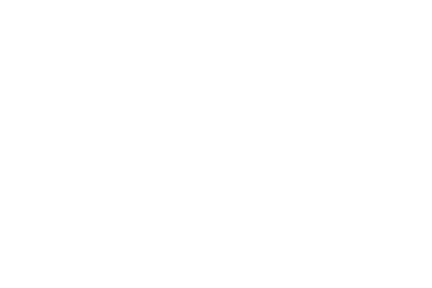

<IPython.core.display.Javascript object>


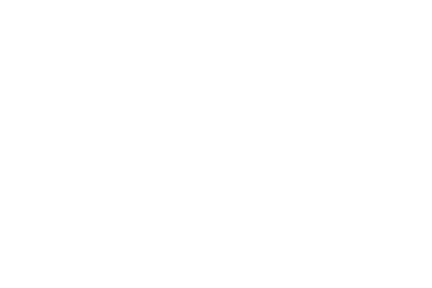

In [117]:
# plt.figure(figsize=(13, 6))
plt.plot(metrics['train_loss'], label='train loss')
plt.plot(metrics['validation_loss'], label='validation loss')
plt.legend()
plt.title('MSE regression Loss.')
plt.grid()
plt.show()

In [37]:
train_samples = train_val_samples.copy()
train_data = flatten_batch_of_samples(train_samples)
target = torch.FloatTensor(list(map(lambda sample: sample.target, train_samples)))
target_pred = model(train_data)

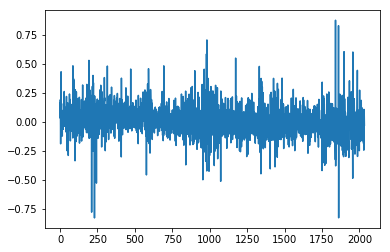

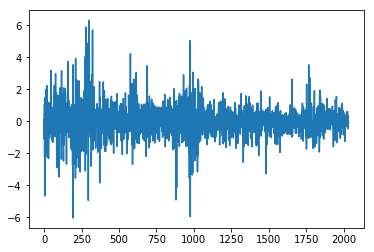

In [38]:
plt.figure()
plt.plot(target_pred.detach().numpy())
plt.figure()
plt.plot(target.detach().numpy())

In [39]:
loss = criterion(list(map(lambda sample: sample.target, train_val_samples)), y_pred)

NameError: name 'y_pred' is not defined